In [1]:
import numpy as np
import pandas as pd
from typing import Optional, Tuple

import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Prepare Data

In [2]:
path = '../input/Kannada-MNIST/'
df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
labels = df_train['label'].values
features = df_train[list(df_train.columns)[1:]].values
features = features.reshape(-1, 28, 28, 1)
features = torch.tensor(features).type(torch.FloatTensor)
features = features.permute(0, 3, 1, 2)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
                                    features, labels, test_size=0.3, random_state=42)

In [5]:
X_train_auto = (X_train - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1
X_test_auto = (X_test - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1

# Implementation

In [6]:
class Layer(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        raise NotImplementedError()

In [7]:
class DeconvLayer(Layer):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 filter_size: int,
                 activation: nn.Module = None,
                 dropout: float = 1.0,
                 flatten: bool = False) -> None:
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, filter_size, 
                                       padding=filter_size // 2)
        self.activation = activation
        self.flatten = flatten
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor) -> Tensor:

        x = self.deconv(x)
        if self.activation:
            x = self.activation(x)
        if self.flatten:
            x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        if hasattr(self, "dropout"):
            x = self.dropout(x)            
            
        return x

In [8]:
class Model(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: Tensor) -> Tuple[Tensor]:
        raise NotImplementedError()

In [9]:
class ConvLayer(Layer):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 filter_size: int,
                 activation: nn.Module = None,
                 dropout: float = 1.0,
                 flatten: bool = False) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, filter_size, 
                              padding=filter_size // 2)
        self.activation = activation
        self.flatten = flatten
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor) -> Tensor:

        x = self.conv(x)
        if self.activation:
            x = self.activation(x)
        if self.flatten:
            x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        if hasattr(self, "dropout"):
            x = self.dropout(x)            
            
        return x

In [10]:
class DenseLayer(Layer):
    def __init__(self,
                 input_size: int,
                 neurons: int,
                 dropout: float = 1.0,
                 activation: nn.Module = None) -> None:

        super().__init__()
        self.linear = nn.Linear(input_size, neurons)
        self.activation = activation
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        if inference:
            self.apply(inference_mode)

        x = self.linear(x)
        if self.activation:
            x = self.activation(x)
        if hasattr(self, "dropout"):
            x = self.dropout(x)

        return x

In [11]:
class Autoencoder(Model):
    def __init__(self,
                 hidden_dim: int = 28):
        super(Autoencoder, self).__init__()
        self.conv1 = ConvLayer(1, 14, 5, activation=nn.Tanh())
        self.conv2 = ConvLayer(14, 7, 5, activation=nn.Tanh(), flatten=True)
        
        self.dense1 = DenseLayer(7 * 28 * 28, hidden_dim, activation=nn.Tanh())
        self.dense2 = DenseLayer(hidden_dim, 7 * 28 * 28, activation=nn.Tanh())
        
        self.conv3 = ConvLayer(7, 14, 5, activation=nn.Tanh()) 
        self.conv4 = ConvLayer(14, 1, 5, activation=nn.Tanh())         

    def forward(self, x: Tensor) -> Tensor:
        assert_dim(x, 4)
            
        x = self.conv1(x)
        x = self.conv2(x)

        encoding = self.dense1(x)
        
        x = self.dense2(encoding)
        
        x = x.view(-1, 7, 28, 28)
        
        x = self.conv3(x)
        x = self.conv4(x)

        return x, encoding

In [12]:
def permute_data(X: Tensor, y: Tensor, seed=1) -> Tuple[Tensor]:
    perm = torch.randperm(X.shape[0])
    return X[perm], y[perm]

def assert_dim(t: Tensor,
               dim: Tensor):
    assert len(t.shape) == dim, \
        '''
        Tensor expected to have dimension {0}, instead has dimension {1}
        '''.format(dim, len(t.shape))
    return None

# Training

In [13]:
class Trainer(object):
    def __init__(self,
                 model: Model,
                 optim: Optimizer,
                 criterion: _Loss):
        self.model = model
        self.optim = optim
        self.loss = criterion
        self._check_optim_net_aligned()

    def _check_optim_net_aligned(self):
        assert self.optim.param_groups[0]['params']\
            == list(self.model.parameters())

    def _generate_batches(self,
                          X: Tensor,
                          y: Tensor,
                          size: int = 32) -> Tuple[Tensor]:

        N = X.shape[0]

        for ii in range(0, N, size):
            X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]

            yield X_batch, y_batch

    def fit(self, X_train: Tensor = None,
            y_train: Tensor = None,
            X_test: Tensor = None,
            y_test: Tensor = None,
            train_dataloader: DataLoader = None,
            test_dataloader: DataLoader = None,
            epochs: int=100,
            eval_every: int=10,
            batch_size: int=32,
            final_lr_exp: int = None):

        init_lr = self.optim.param_groups[0]['lr']
        if final_lr_exp:
            decay = (final_lr_exp / init_lr) ** (1.0 / (epochs + 1))
            scheduler = lr_scheduler.ExponentialLR(self.optim, gamma=decay)
        for e in range(epochs):

            if final_lr_exp:
                scheduler.step()

            if not train_dataloader:
                X_train, y_train = permute_data(X_train, y_train)

                batch_generator = self._generate_batches(X_train, y_train,
                                                         batch_size)

                self.model.train()

                for ii, (X_batch, y_batch) in enumerate(batch_generator):

                    self.optim.zero_grad()

                    output = self.model(X_batch)[0]

                    loss = self.loss(output, y_batch)
                    loss.backward()
                    self.optim.step()

                if e % eval_every == 0:
                    with torch.no_grad():
                        self.model.eval()
                        output = self.model(X_test)[0]
                        loss = self.loss(output, y_test)
                        print("Epoch:", e+1, ", Loss:", loss.item())

            else:
                for X_batch, y_batch in train_dataloader:

                    self.optim.zero_grad()

                    output = self.model(X_batch)[0]

                    loss = self.loss(output, y_batch)
                    loss.backward()
                    self.optim.step()

                if e % eval_every == 0:
                    with torch.no_grad():
                        self.model.eval()
                        losses = []
                        for X_batch, y_batch in test_dataloader:
                            output = self.model(X_batch)[0]
                            loss = self.loss(output, y_batch)
                            losses.append(loss.item())
                        print("Epoch:", e, ", Loss:",
                              round(torch.Tensor(losses).mean().item(), 4))

In [14]:
model = Autoencoder(hidden_dim=28)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

trainer = Trainer(model, optimizer, criterion)

trainer.fit(X_train_auto, X_train_auto,
            X_test_auto, X_test_auto,
            epochs=10,
            batch_size=60)

Epoch: 1 , Loss: 0.11038662493228912


# Reconstruct image from trained model

In [15]:
reconstructed_images, image_representations = model(X_test_auto)

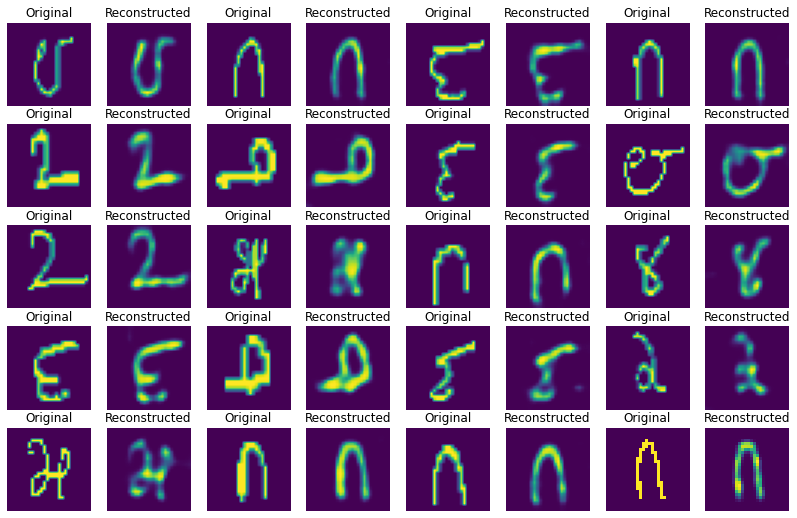

In [16]:
def display_image(ax,
    t: Tensor):
    n = t.detach().numpy()
    ax.imshow(n.reshape(28, 28))

f, axarr = plt.subplots(5,8, figsize=(14,9))

k = 0
for i in range(5):
    
    for j in range(7):
        display_image(axarr[i][j + (j % 2)], X_test[k])
        display_image(axarr[i][j + (j % 2 + 1)], reconstructed_images[k])
        k += 1

    for j in range(7):
        axarr[i][j + (j % 2)].set_title("Original")
        axarr[i][j + (j % 2 + 1)].set_title("Reconstructed")

    for j in range(7):
        axarr[i][j + (j % 2)].axis('off')
        axarr[i][j + (j % 2 + 1)].axis('off')